In [1]:
from data_base import *

data = DataBase(summary=True, max_size=10**5)

Whole text size: 36161157 so used 100000
Alphabet length: 160
Alphabet:  !"#%&'()*,-./0123456789:;<=>?@[]^_`abcdefghijklmnopqrstuvwxyz{|}~§«°·»½¾ßàáâäçèéêëíîïòóôöùúûüýœ̀́γεθιλοστυώабвгдежзийклмнопрстуфхцчшщъыьэюяёєіїљќѣ‑–—’“”„…№


In [4]:
import numpy as np
np.random.seed(80085)

input_len = 15

data.text_size = data.text_size - input_len
print('Train data size:', data.text_size)

X = np.zeros((data.text_size, input_len), dtype=np.float64)
Y = np.zeros((data.text_size, data.alph_len), dtype=np.int8)


def text_to_indexes(text):
    return np.array([data.letter_index[s] for s in text])


for i in tqdm(range(input_len, data.text_size)):
    fragment = data.whole_text[i-input_len : i]
    X[i-input_len] = text_to_indexes(fragment)
    
    letter_ind = data.letter_index[data.whole_text[i]]
    Y[i-input_len][letter_ind] = 1
    
print('X shape:', X.shape)
print('Y shape:', Y.shape)

print(X)
print(Y)

Train data size: 99955


100%|██████████| 99940/99940 [00:00<00:00, 143645.52it/s]

X shape: (99955, 15)
Y shape: (99955, 160)
[[129. 122. 112. ...  13.   3. 122.]
 [122. 112. 119. ...   3. 122. 126.]
 [112. 119. 122. ... 122. 126. 130.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, LeakyReLU, Conv1D

import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

batch_size = 64
dropout_val = 0.1
embending_size = 256

model = Sequential([
    Embedding(data.alph_len, embending_size, input_length=input_len),
    Conv1D(32, 5, strides=1, padding='same'), LeakyReLU(),
    Dropout(dropout_val),
    
    Conv1D(64, 5, strides=1, padding='same'), LeakyReLU(),
    Dropout(dropout_val),

    Flatten(),
    Dense(data.alph_len, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X, Y, epochs=1, validation_split=0.2, batch_size=batch_size)

model.save('LP')

Num GPUs Available:  1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 256)           40960     
                                                                 
 conv1d (Conv1D)             (None, 15, 32)            40992     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 15, 32)            0         
                                                                 
 dropout (Dropout)           (None, 15, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 64)            10304     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 15, 64)            0         
                                                                 
 dropout_1 (Dropout)         (Non

INFO:tensorflow:Assets written to: LP\assets


INFO:tensorflow:Assets written to: LP\assets


(0.0, 1.0)

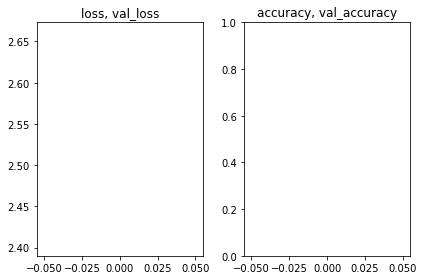

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title("loss, val_loss")

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_title("accuracy, val_accuracy")
axs[1].set_ylim([0, 1])

In [10]:
def match_to_letters(prediction):
    return {data.alphabet[i]: prediction[i] for i in range(data.alph_len)}

def letter_of_pred(prediction) -> str:
    return data.alphabet[prediction.argmax()]


letters_predicted = 0
predictability = 0
n = 10_000
#n = data.text_size

predictions = model.predict(X[:n])

for i in tqdm(range(n)):
    prediction = predictions[i]
    next_letter = data.whole_text[i + input_len]

    predictability += match_to_letters(prediction)[next_letter]
    letters_predicted += 1 if letter_of_pred(prediction) == next_letter else 0

predictability /= n - input_len
letters_predicted /= n - input_len
print('Predicted ', round(letters_predicted*100, 2), '% of letters')
print('Predictability of russian language is', round(predictability*100, 2), '%')

313/313 [==============================] - 2s 5ms/step


100%|██████████| 10000/10000 [00:00<00:00, 20174.65it/s]

Predicted  29.76 % of letters
Predictability of russian language is 17.92 %


In [11]:
#test_text = 'приветики, съешь ещё этих мягких французских булочек да выпей чаю'
#test_text = 'и снова седая ночь, и только ей доверяю я, знаешь седая ночь что-то та-а-ам'
#test_text = 'мне нужно это предложение, чтобы протестировать некий анализ йей!'
#test_text = prepare_text("Если посмотреть из чего получается оригинальная мысль, то можем выделить следующие факторы: личные ценности, культурный опыт, перспектива и взгляд на мир, эмоциональные и интуитивные компоненты. Из этого и складывается индивидуальность творца-человека. ИИ не обладает эмоциями. Но что из этого не может быть имитировано? Он не может обладать ничем из перечисленного, ведь это все присуще живым и мыслящим существам, а ИИ не живой; однако он может все это впитать и воссоздать в себе. Эти факторы – следствие всего пережитого, всего накопленного и отпечатанного опыта. А впитывать опыт – то, что ИИ и делают и способны делать это лучше нас и в гораздо большем объеме, чем способны люди, ведь ИИ не органичен физиологическими факторами.")
test_text = prepare_text("Если посмотреть из чего получается оригинальная мысль, то можем выделить следующие факторы: личные ценности, культурный опыт, перспектива и взгляд на мир, эмоциональные и интуитивные компоненты. Из этого и складывается индивидуальность творца-человека. ИИ не обладает эмоциями. Но что из этого не может быть имитировано? Он не может обладать ничем из перечисленного, ведь это все присуще живым и мыслящим существам, а ИИ не живой; однако он может все это впитать и воссоздать в себе. Эти факторы - следствие всего пережитого, всего накопленного и отпечатанного опыта. А впитывать опыт - то, что ИИ и делают и способны делать это лучше нас и в гораздо большем объеме, чем способны люди, ведь ИИ не органичен физиологическими факторами.")

r = test_text[:input_len]

for i in tqdm(range(input_len, len(test_text))):
    #frag = test_text[i-input_len : i]
    fragment = r[-input_len:]
    fragment = text_to_indexes(fragment)
    prediction = model.predict(np.array([fragment]), verbose=0)[0]

    if match_to_letters(prediction)[test_text[i]] > 0.10 and test_text[i] != ' ':
    #if letter_of_pred(prediction) == test_text[i] and test_text[i] != ' ':
        r += ''
    else:
        r += test_text[i]

print(r)
print('Original length:', len(test_text))
print('Compressed length:', len(r))
print('Compression:', len(r) / len(test_text))

100%|██████████| 719/719 [00:45<00:00, 15.74it/s]

если посмотреть из чг плучтс оргнльая мысль, т мжм выдлть следующ фктры: лчные цннси, культурнй опыт, перспктив  взгляд н мир, эмционльые и интуитвные кмпнеты. з эог и склдывтс ндвидуальось тврц-члвк.  н блдт эмцями н чт и эог н мжт бть имитироао? он н мжт облдть ничм и ерчслннг, ведь эо в риущ жвы  мыслящм ущствм, а ии е живй; однк н мжт вс эо впитть и воссоздть  еб. эи фктры - слдсв вг пеежтг, всг нкплеог  тпечатаннг пыт. а питывть пыт - т, чо ии и длют и особны длть эо лучш а и в газдо бльшм объм, чм псобны люд, ведь ии н оргнич физиологичскими фктрм.
Original length: 734
Compressed length: 560
Compression: 0.7629427792915532
